# Multiscale example in one dimension

This script will apply the FEM to a one dimensional example of a multiscale problem. This problem was introduced by
Peterseim in "Variational Multiscale Stabilization and the Exponential Decay of correctors, p.2".

$$
\begin{cases}
		- (A_{\varepsilon}(x)u'_{\varepsilon}(x))' &= 1, \qquad \text{ for }x \in (0,1)\\
		u_{\varepsilon}(0)= u_{\varepsilon}(1) &= 0,
	\end{cases}
$$
where, for $\varepsilon >0$,
$$
	A_{\varepsilon}(x) := \frac{1}{4}\left( 2 - \cos \left(\frac{2 \pi x}{\varepsilon}\right) \right)^{-1}.
$$
The exact solution is given by 
$$
	u_{\varepsilon}(x) = 4 (x-x^2)- 4 \varepsilon \left( \frac{1}{4 \pi} \sin(2 \pi \frac{x}{\varepsilon}) - \frac{1}{2 \pi}x \sin(2 \pi \frac{x}{\varepsilon}) - 
	\frac{\varepsilon}{4 \pi^2} \cos(2 \pi \frac{x}{\varepsilon}) + \frac{\varepsilon}{4 \pi^2} \right).
$$

In order to demonstrate the difficulty that comes with multiscale problems in terms of the FEM, we use several choices of the mesh size $h$ and compare the energy error.

In [1]:
import os
import sys
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

from gridlod import util, world, fem
from gridlod.world import World
import femsolverCoarse

First, we define the given functions and furthermore, we visualize the coefficient for two choices of epsilon. 

<IPython.core.display.Javascript object>


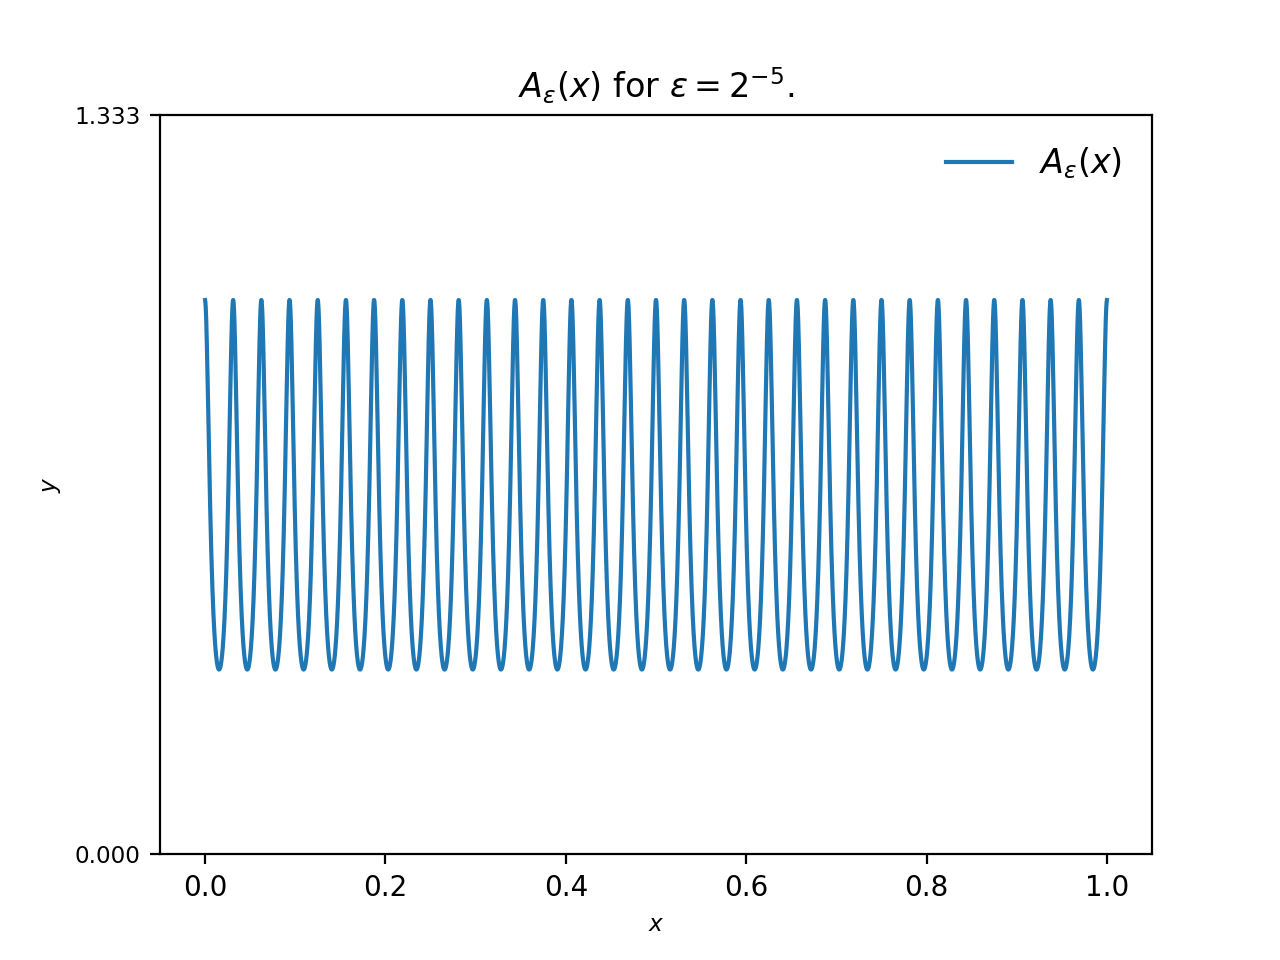

<IPython.core.display.Javascript object>


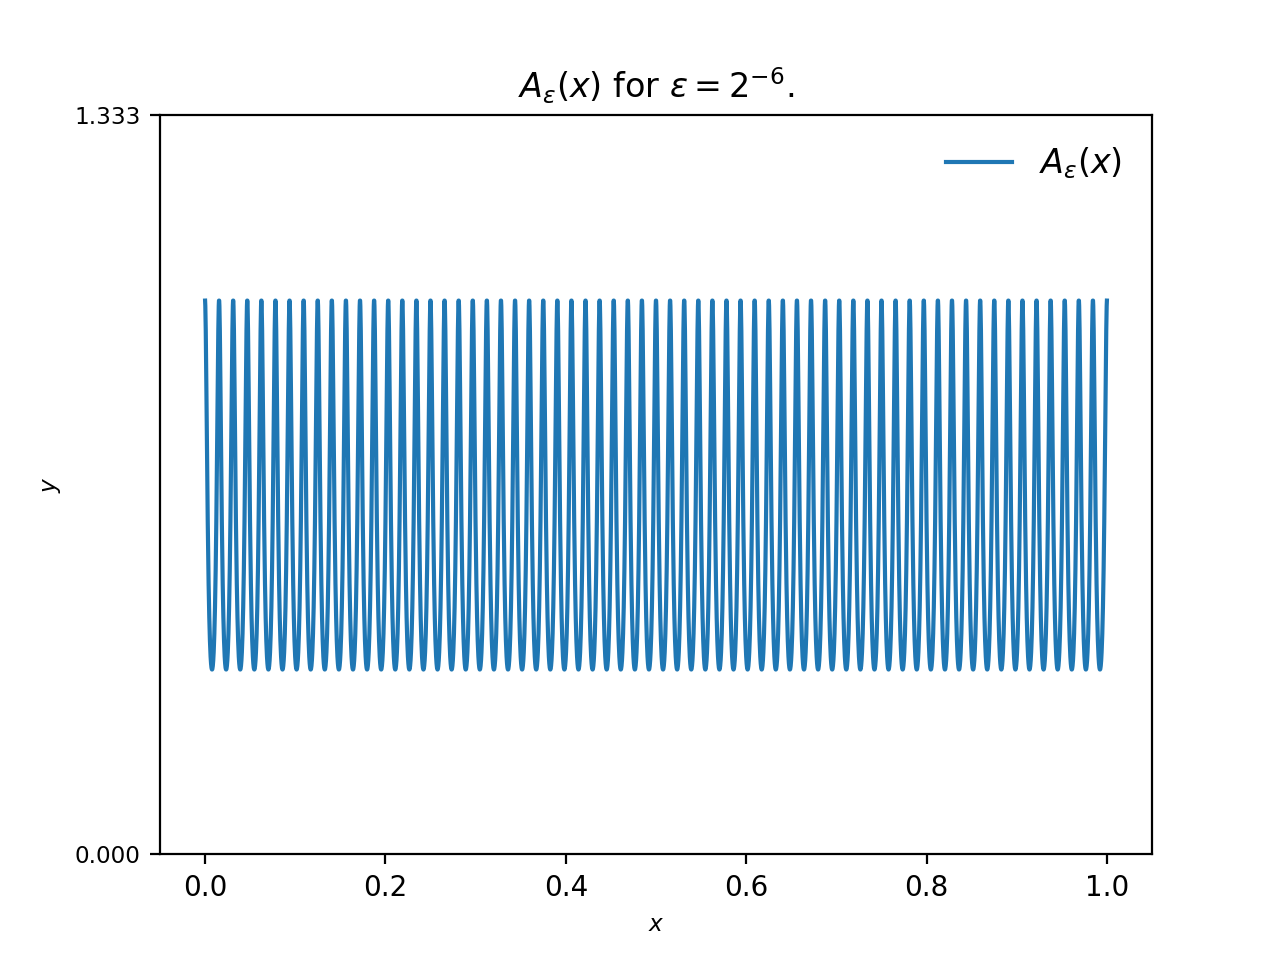

In [3]:
fine = 4096
NFine = np.array([fine])
NpFine = np.prod(NFine+1)
NList = [2,4,8,16, 32, 64, 128, 256]

epsilon = 2**(-5)
epsilon1 = 2**(-6)

pi = np.pi
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()

aFine = (2 - np.cos(2*pi*xt/epsilon))**(-1)
aFine1 = (2 - np.cos(2*pi*xt/epsilon1))**(-1)

uSol  = 4*(xp - xp**2) - 4*epsilon*(1/(4*pi)*np.sin(2*pi*xp/epsilon) -
                                    1/(2*pi)*xp*np.sin(2*pi*xp/epsilon) -
                                    epsilon/(4*pi**2)*np.cos(2*pi*xp/epsilon) +
                                    epsilon/(4*pi**2))

uSol = uSol/4

# plot the coefficient
plt.figure('Coefficient')
plt.plot(xt,aFine, label='$A_{\epsilon}(x)$')
plt.yticks((0,np.max(aFine)+np.min(aFine)),fontsize="small")
plt.ylabel('$y$', fontsize="small")
plt.xlabel('$x$', fontsize="small")
plt.legend(frameon=False,fontsize="large")
plt.title('$A_{\epsilon}(x)$ for $\epsilon=2^{-5}$.')
plt.show()

# plot the coefficient for a smaller epsilon
plt.figure('Coefficient1')
plt.plot(xt,aFine1, label='$A_{\epsilon}(x)$')
plt.yticks((0,np.max(aFine)+np.min(aFine1)),fontsize="small")
plt.ylabel('$y$', fontsize="small")
plt.xlabel('$x$', fontsize="small")
plt.legend(frameon=False,fontsize="large")
plt.title('$A_{\epsilon}(x)$ for $\epsilon=2^{-6}$.')
plt.show()

We compute the FEM approximation for each mesh size, plot the result and store the energy error. In order to apply the FEM, our computations are based on the 'gridlod' framework but with a coarse right hand side.   

<IPython.core.display.Javascript object>


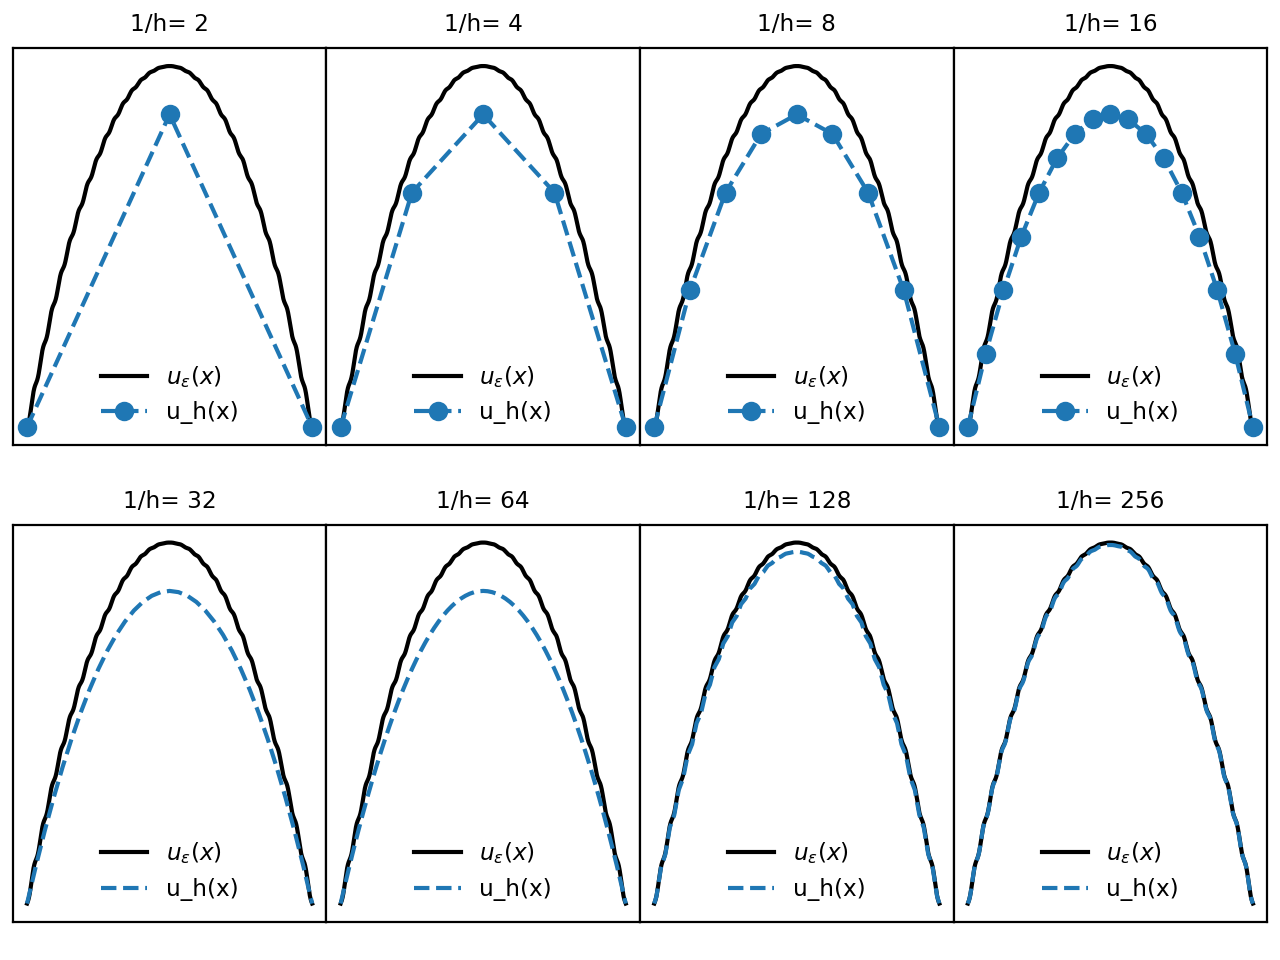

In [3]:
newErrorFine = []
x = []
y = []
for N in NList:
    NWorldCoarse = np.array([N])
    boundaryConditions = np.array([[0, 0]])

    NCoarseElement = NFine/NWorldCoarse
    world = World(NWorldCoarse, NCoarseElement, boundaryConditions)
    AFine = fem.assemblePatchMatrix(NFine, world.ALocFine, aFine)
    
    #grid nodes
    xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
    NpCoarse = np.prod(NWorldCoarse+1)
    f = np.ones(NpCoarse)
    uCoarseFull = femsolverCoarse.solveCoarse_fem(world, aFine, f, boundaryConditions)
    
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    uLodCoarse = basis*uCoarseFull
    newErrorFine.append(np.sqrt(np.dot(uSol - uLodCoarse, AFine*(uSol - uLodCoarse))))
    x.append(N)
    y.append(1./N)
    if np.size(x)==1:
        plt.figure('FEM-Solutions')
        plt.subplots_adjust(left=0.01,bottom=0.04,right=0.99,top=0.95,wspace=0,hspace=0.2)
        plt.subplot(241)
        plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
        plt.plot(xpCoarse,uCoarseFull,'o--', label= 'u_h(x)')
        plt.title('1/h= ' + str(N),fontsize="small")
        plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        plt.legend(frameon=False,fontsize="small")
    elif np.size(x)==2:
        plt.subplot(242)
        plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
        plt.plot(xpCoarse,uCoarseFull,'o--', label= 'u_h(x)')
        plt.title('1/h= ' + str(N),fontsize="small")
        plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        plt.legend(frameon=False,fontsize="small")
    elif np.size(x)==3:
        plt.subplot(243)
        plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
        plt.plot(xpCoarse,uCoarseFull,'o--', label= 'u_h(x)')
        plt.title('1/h= ' + str(N),fontsize="small")
        plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        plt.legend(frameon=False,fontsize="small")
    elif np.size(x)==4:
        plt.subplot(244)
        plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
        plt.plot(xpCoarse,uCoarseFull,'o--', label= 'u_h(x)')
        plt.title('1/h= ' + str(N),fontsize="small")
        plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        plt.legend(frameon=False,fontsize="small")
    elif np.size(x)==5:
        plt.subplot(245)
        plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
        plt.plot(xpCoarse,uCoarseFull,'--', label= 'u_h(x)')
        plt.title('1/h= ' + str(N),fontsize="small")
        plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        plt.legend(frameon=False,fontsize="small")
    elif np.size(x)==6:
        plt.subplot(246)
        plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
        plt.plot(xpCoarse,uCoarseFull,'--', label= 'u_h(x)')
        plt.title('1/h= ' + str(N),fontsize="small")
        plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        plt.legend(frameon=False,fontsize="small")
    elif np.size(x)==7:
        plt.subplot(247)
        plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
        plt.plot(xpCoarse,uCoarseFull,'--', label= 'u_h(x)')
        plt.title('1/h= ' + str(N),fontsize="small")
        plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        plt.legend(frameon=False,fontsize="small")
    elif np.size(x)==8:
        plt.subplot(248)
        plt.plot(xp,uSol,'k', label='$u_{\epsilon}(x)$')
        plt.plot(xpCoarse,uCoarseFull,'--', label= 'u_h(x)')
        plt.title('1/h= ' + str(N),fontsize="small")
        plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        plt.legend(frameon=False,fontsize="small")
plt.show()

Lastly, we plot the energy error.

<IPython.core.display.Javascript object>


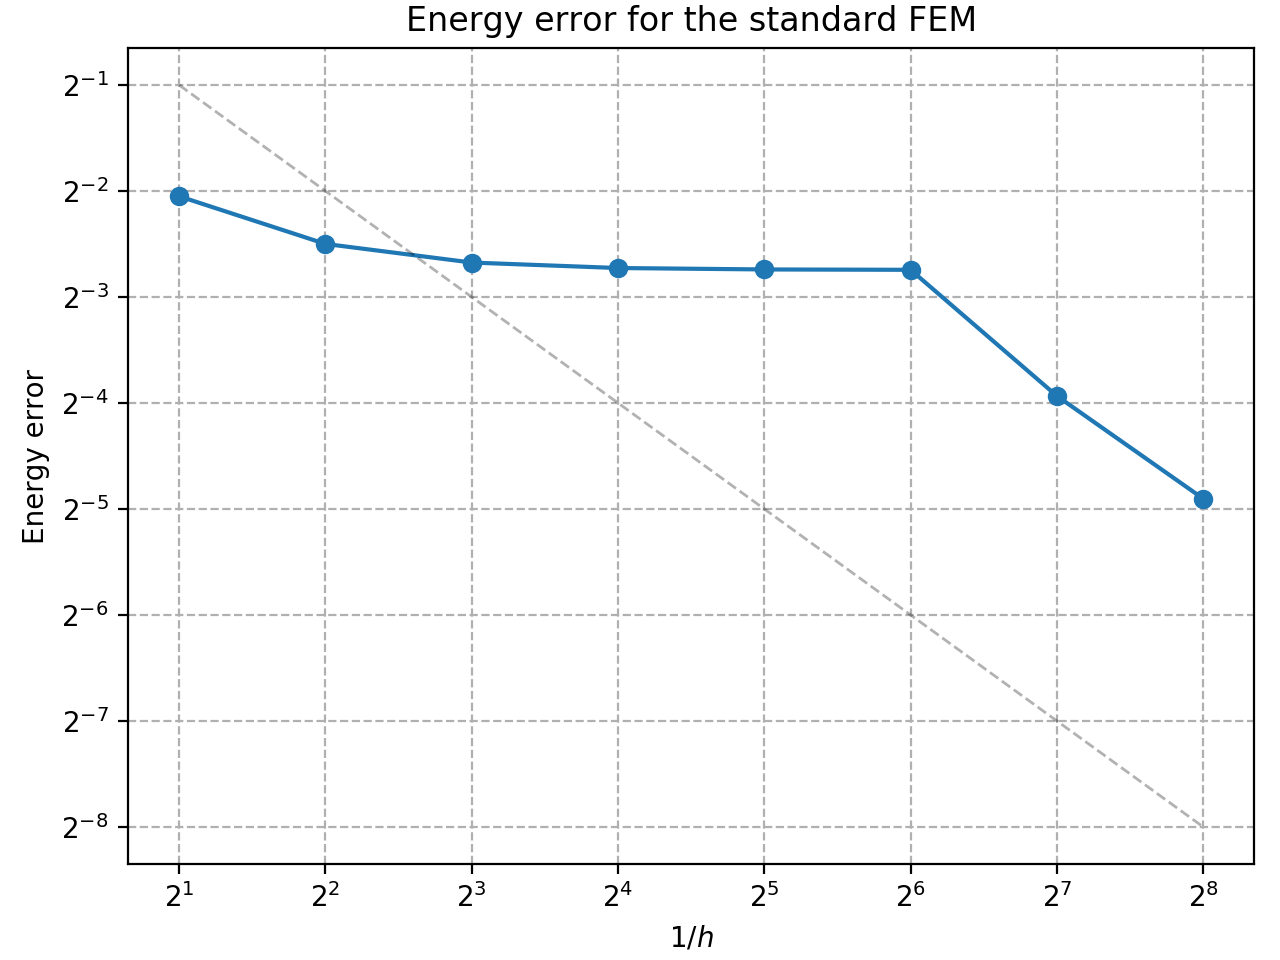

In [4]:
plt.figure("Error")
plt.loglog(x,newErrorFine,'o-', basex=2, basey=2)
plt.loglog(x,y,'--k',basex=2, basey=2, linewidth=1, alpha=0.3)
plt.ylabel('Energy error')
plt.xlabel('$1/h$')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.98,top=0.95,wspace=0.2,hspace=0.2)
plt.title('Energy error for the standard FEM')
plt.grid(True,which="both",ls="--")
plt.show()